In [1]:
# 필요한 모듈 import하기

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.applications import EfficientNetB0
from glob import glob
from pprint import pprint

import os
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

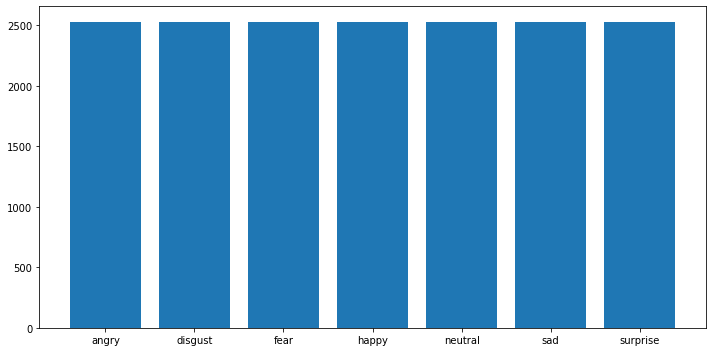

In [2]:
csv_path = './feelings_skfold2.csv'
df = pd.read_csv(csv_path)
np.unique(df['emotion'])

value_counts = df['emotion'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(range(len(value_counts)), value_counts.values)
plt.xticks(range(len(value_counts)), value_counts.index.values)
plt.tight_layout()
plt.show()

# 1. Model 정의하기

* binary crossentropy : binary 다중 분류 손실 함수 -> label들이 독립적일 때 사용함
* categorical_crossentropy : 다중 분류 손실 함수, 출력값이 one-hot encoding된 결과로 나옴
* (정답에만 1으로 표시하고, 나머지는 0으로)
* 각 샘플이 정확히 하나의 클래스에 속하는 경우 사용한다.
* sparse_categorical_crossentropy : 다중 분류 손실 함수, one - hot - encoding을 하지 않고 정수 형태로 넣어줌, 한 샘플에 여러 클래스가 있거나 label이 soft 확률일 경우 사용

* softmax
- 출력은 0 ~ 1 사이의 실수
- 출력을 확률로 해석할 수 있음
- 출력의 총합은 1이다.

In [3]:
def get_model(input_shape):
    inputs = keras.Input(input_shape)
    base_model = EfficientNetB0(
        input_shape = input_shape,
        weights = 'imagenet', 
        include_top = False,
        pooling = 'avg'
    )
    
    x = base_model(inputs)
    output = layers.Dense(7,activation = 'softmax')(x) # 클래스의 개수만큼 layer를 쌓아준다.
    model = keras.Model(inputs,output)
    return model

input_shape = (48,48,3)    # 가로 * 세로, 색상값 / 3을 안 넣으면 에러남..(why..?)
model = get_model(input_shape)

adam = keras.optimizers.Adam(lr = 0.0001)

model.compile(
    optimizer = adam,
    loss = 'sparse_categorical_crossentropy', # 다중 분류 손실 함수
    metrics = 'accuracy'
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 4,016,515
Non-trainable params: 42,023
_________________________________________________________________


c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [4]:
import albumentations as A

# Albumentation class 생성하기
class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                # 수평 전환
                A.HorizontalFlip(p=0.5),
                # 이동, 크기, 회전을 설정
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                # 구멍을 dropout 하게됨
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8, # 최대 8개의 구멍을 dropout 시킴
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2) # 밝기 대비
            ])
    
    def __call__(self, **kwargs): # callback 함수: 클래스의 객체를 생성한 이후 객체를 호출할 떄 자동으로 실행되는 함수
        if self.transform:
            augmented = self.transform(**kwargs) # **kwargs : 가변 인수(파라미터의 개수에 제한을 두지 않겠다.)
            img = augmented['image'] # 증폭된 이미지
            return img 

In [5]:
csv_path = './feelings_skfold2.csv'

LABEL_INT_DICT = np.unique(pd.read_csv(csv_path)['emotion'])
pprint(LABEL_INT_DICT) # 데이터의 타입과 형태 등도 같이 보여준다.(조금 더 예쁘게 출력해준다?)
LABEL_STR_DICT = {k:v for v,k in enumerate(LABEL_INT_DICT)}
pprint(LABEL_STR_DICT)# Keras의 Sequential model 이용

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)
{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}


In [6]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
            
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()

        
    def on_epoch_end(self):
        if self.shuffle: # shuffle = True라면(df 앞의 인덱스를 지워주는 기능
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    # len()
    def __len__(self):
            return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            img_folder = r['emotion'] # type = np.str_

            image = cv2.imread(f'datasets/{img_folder}/{file_name}.jpg',cv2.IMREAD_GRAYSCALE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8') # 정수로 형변환
                image = self.transform(image=image)

            image = image.astype('float32') # 실수로 다시 형변환         
            image = image / 255.

            
            emotion = str(img_folder)  
            emotion = LABEL_STR_DICT[emotion]
            
            batch_x.append(image)
            batch_y.append(emotion)
        
        return batch_x, batch_y
    

In [7]:
csv_path = './feelings_skfold2.csv'

train_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 48,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1, 
    image_size = 48,
    mode = 'val',
    shuffle = True
)

In [8]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    verbose = 1
)

Epoch 1/10
111/111 [==============================] - 85s 727ms/step - loss: 2.0256 - accuracy: 0.1959 - val_loss: 2.0101 - val_accuracy: 0.1428
Epoch 2/10
111/111 [==============================] - 76s 685ms/step - loss: 1.8560 - accuracy: 0.2667 - val_loss: 2.0317 - val_accuracy: 0.1433
Epoch 3/10
111/111 [==============================] - 76s 687ms/step - loss: 1.7769 - accuracy: 0.3098 - val_loss: 2.0915 - val_accuracy: 0.1498
Epoch 4/10
111/111 [==============================] - 76s 687ms/step - loss: 1.7038 - accuracy: 0.3432 - val_loss: 2.0689 - val_accuracy: 0.1445
Epoch 5/10
111/111 [==============================] - 76s 686ms/step - loss: 1.6468 - accuracy: 0.3647 - val_loss: 2.1047 - val_accuracy: 0.1637
Epoch 6/10
111/111 [==============================] - 76s 686ms/step - loss: 1.6065 - accuracy: 0.3863 - val_loss: 2.0864 - val_accuracy: 0.1718
Epoch 7/10
111/111 [==============================] - 76s 686ms/step - loss: 1.5503 - accuracy: 0.4125 - val_loss: 2.0589 - val_ac

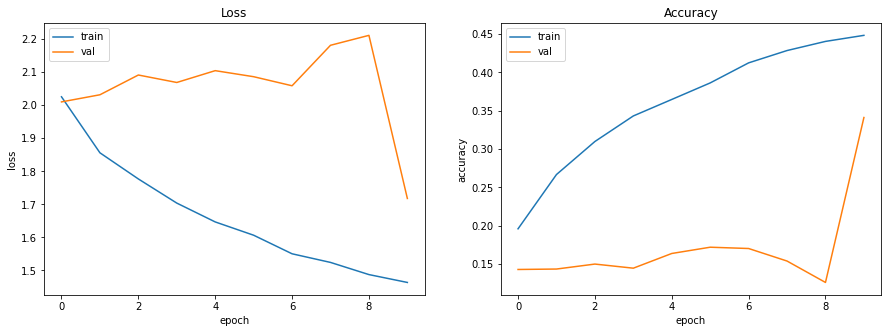

In [9]:
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()

In [10]:
csv_path2 = './feelings_skfold2.csv'

train_generator2 = DataGenerator(
    batch_size = 64,
    csv_path = csv_path2,
    fold = 1,
    image_size = 48,
    mode = 'train',
    shuffle = True
)

valid_generator2 = DataGenerator(
    batch_size = 64,
    csv_path = csv_path2,
    fold = 1, 
    image_size = 48,
    mode = 'val',
    shuffle = True
)

In [11]:
history2 = model.fit(
    train_generator2,
    validation_data = valid_generator2,
    epochs = 10,
    verbose = 1
)

Epoch 1/10
222/222 [==============================] - 84s 380ms/step - loss: 1.4544 - accuracy: 0.4496 - val_loss: 1.9375 - val_accuracy: 0.2314
Epoch 2/10
222/222 [==============================] - 85s 381ms/step - loss: 1.4028 - accuracy: 0.4796 - val_loss: 2.1514 - val_accuracy: 0.1287
Epoch 3/10
222/222 [==============================] - 84s 380ms/step - loss: 1.3817 - accuracy: 0.4845 - val_loss: 2.0314 - val_accuracy: 0.2102
Epoch 4/10
222/222 [==============================] - 85s 383ms/step - loss: 1.3500 - accuracy: 0.5019 - val_loss: 2.1348 - val_accuracy: 0.1428
Epoch 5/10
222/222 [==============================] - 85s 382ms/step - loss: 1.3081 - accuracy: 0.5114 - val_loss: 2.2433 - val_accuracy: 0.1673
Epoch 6/10
222/222 [==============================] - 85s 382ms/step - loss: 1.2845 - accuracy: 0.5219 - val_loss: 2.2716 - val_accuracy: 0.1524
Epoch 7/10
222/222 [==============================] - 85s 383ms/step - loss: 1.2607 - accuracy: 0.5300 - val_loss: 2.0927 - val_ac

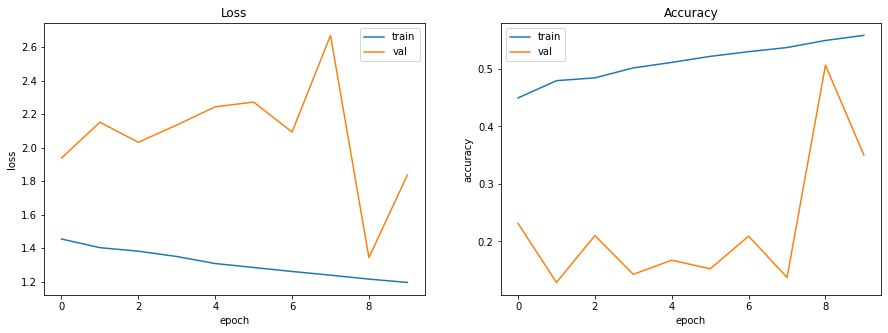

In [12]:
history2 = history2.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history2['loss'], label='train')
plt.plot(history2['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history2['accuracy'], label='train')
plt.plot(history2['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()

In [13]:
csv_path = './feelings_skfold2.csv'

train_generator3 = DataGenerator(
    batch_size = 256,
    csv_path = csv_path,
    fold = 1,
    image_size = 48,
    mode = 'train',
    shuffle = True
)

valid_generator3 = DataGenerator(
    batch_size = 256,
    csv_path = csv_path,
    fold = 1, 
    image_size = 48,
    mode = 'val',
    shuffle = True
)

In [14]:
history3 = model.fit(
    train_generator3,
    validation_data = valid_generator3,
    epochs = 10,
    verbose = 1
)

Epoch 1/10
56/56 [==============================] - 70s 1s/step - loss: 1.1272 - accuracy: 0.5861 - val_loss: 1.8098 - val_accuracy: 0.3544
Epoch 2/10
56/56 [==============================] - 70s 1s/step - loss: 1.1007 - accuracy: 0.5928 - val_loss: 1.4388 - val_accuracy: 0.4771
Epoch 3/10
56/56 [==============================] - 70s 1s/step - loss: 1.0991 - accuracy: 0.5949 - val_loss: 1.8198 - val_accuracy: 0.3617
Epoch 4/10
56/56 [==============================] - 70s 1s/step - loss: 1.0873 - accuracy: 0.5982 - val_loss: 1.9657 - val_accuracy: 0.2884
Epoch 5/10
56/56 [==============================] - 70s 1s/step - loss: 1.0755 - accuracy: 0.6041 - val_loss: 2.1430 - val_accuracy: 0.2633
Epoch 6/10
56/56 [==============================] - 70s 1s/step - loss: 1.0685 - accuracy: 0.6059 - val_loss: 2.6645 - val_accuracy: 0.1543
Epoch 7/10
56/56 [==============================] - 70s 1s/step - loss: 1.0551 - accuracy: 0.6049 - val_loss: 1.8324 - val_accuracy: 0.3490
Epoch 8/10
56/56 [==

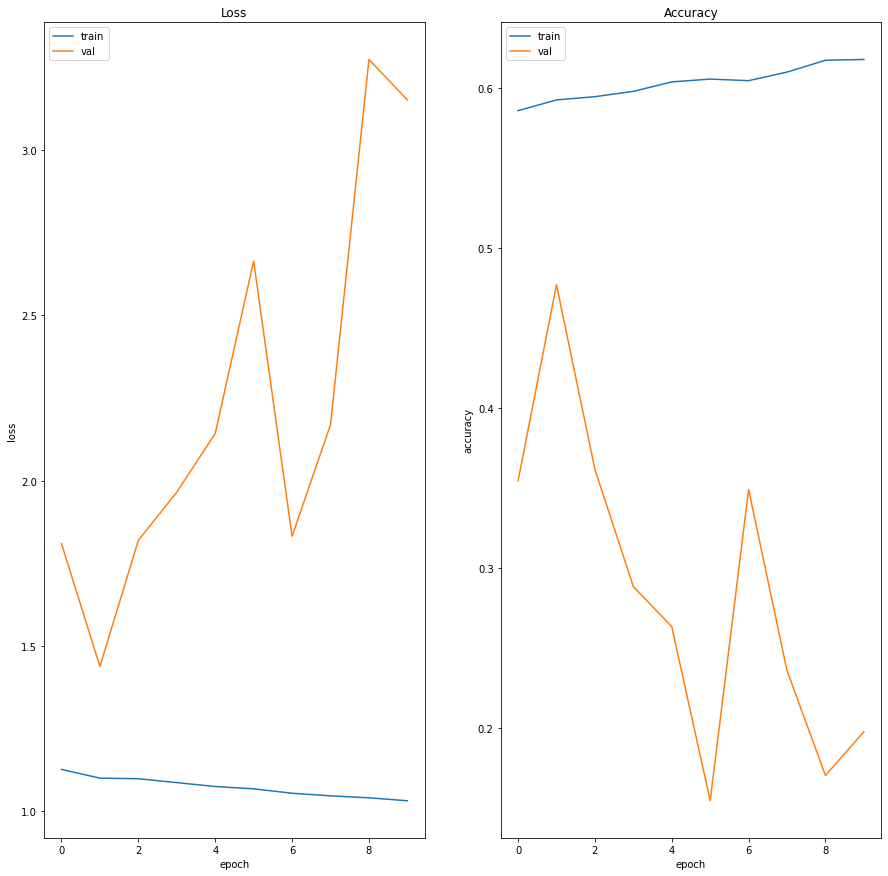

In [15]:
history3 = history3.history

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(history3['loss'], label='train')
plt.plot(history3['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history3['accuracy'], label='train')
plt.plot(history3['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()

In [16]:
csv_path4 = './feelings_skfold2.csv'

train_generator4 = DataGenerator(
    batch_size = 128,
    csv_path = csv_path4,
    fold = 1,
    image_size = 48,
    mode = 'train',
    shuffle = True
)

valid_generator4 = DataGenerator(
    batch_size = 128,
    csv_path = csv_path4,
    fold = 1, 
    image_size = 48,
    mode = 'val',
    shuffle = True
)

In [18]:
history4 = model.fit(
    train_generator4,
    validation_data = valid_generator4,
    epochs = 20,
    verbose = 1
)

Epoch 1/20
111/111 [==============================] - 76s 686ms/step - loss: 1.0392 - accuracy: 0.6170 - val_loss: 2.9356 - val_accuracy: 0.1332
Epoch 2/20
111/111 [==============================] - 76s 684ms/step - loss: 1.0383 - accuracy: 0.6157 - val_loss: 1.6970 - val_accuracy: 0.3953
Epoch 3/20
111/111 [==============================] - 76s 684ms/step - loss: 1.0212 - accuracy: 0.6222 - val_loss: 2.6221 - val_accuracy: 0.1315
Epoch 4/20
111/111 [==============================] - 76s 684ms/step - loss: 0.9977 - accuracy: 0.6389 - val_loss: 2.3596 - val_accuracy: 0.2384
Epoch 5/20
111/111 [==============================] - 76s 685ms/step - loss: 0.9833 - accuracy: 0.6401 - val_loss: 2.1838 - val_accuracy: 0.1876
Epoch 6/20
111/111 [==============================] - 76s 685ms/step - loss: 0.9649 - accuracy: 0.6475 - val_loss: 2.9105 - val_accuracy: 0.1591
Epoch 7/20
111/111 [==============================] - 76s 685ms/step - loss: 0.9477 - accuracy: 0.6543 - val_loss: 2.2175 - val_ac

KeyboardInterrupt: 

In [ ]:
history4 = history4.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history4['loss'], label='train')
plt.plot(history4['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history4['accuracy'], label='train')
plt.plot(history4['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()